# Breve Explicacion
El objetivo de este cuaderno es entrenar un único modelo capaz de distinguir entre las clases AP, PA, L y Otros, para luego compararlo con el filtro bietápico y así poder decidir el enfoque a utilizar en el sistema definitivo. 

# Montaje e Importación 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation,RandomFlip,Rescaling
from tensorflow.keras.callbacks import EarlyStopping
import shutil
from tensorflow.keras.models import load_model, Model, Sequential
from matplotlib import pyplot as plt
from tensorflow.keras import applications

In [ ]:
!pip install -q --upgrade wandb
import wandb
from wandb.keras import WandbCallback
wandb.login()

     |████████████████████████████████| 1.8MB 7.7MB/s 
     |████████████████████████████████| 174kB 46.4MB/s 
     |████████████████████████████████| 133kB 51.8MB/s 
     |████████████████████████████████| 102kB 15.5MB/s 
     |████████████████████████████████| 71kB 12.1MB/s 


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./03. Utils')
import importlib
importlib.reload(MyFunctions)
#import MyFunctions

# Modelo

In [ ]:
IMAGE_SIZE = (128,128)
NUM_CLASSES = 4 
BATCH_SIZE = 32 

In [ ]:
df_train=pd.read_csv("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/train_filter_set.csv")
df_test=pd.read_csv("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/test_filter_set.csv")

In [ ]:
train_datagen = ImageDataGenerator(validation_split = 0.2,rescale = 1./255,horizontal_flip=True,rotation_range=40)
dir = '/content/'
train_batches = train_datagen.flow_from_dataframe( 
    df_train, 
    directory=dir,
    x_col='Path',y_col='class_name',
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=BATCH_SIZE,
    subset = "training",
    seed=42,
    class_mode="categorical",)

Found 15762 validated image filenames belonging to 4 classes.


In [ ]:
valid_batches = train_datagen.flow_from_dataframe(df_train, directory=dir,
                                            x_col='Path',y_col='class_name',
                                            target_size=IMAGE_SIZE,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            subset = "validation",
                                            seed=42,
                                            class_mode="categorical",)

Found 3940 validated image filenames belonging to 4 classes.


In [ ]:
base_model = applications.resnet50.ResNet50(weights= 'imagenet', include_top=False, input_shape= (IMAGE_SIZE[0], IMAGE_SIZE[1], 3) )
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(NUM_CLASSES , activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
from keras.optimizers import SGD, Adam
adam = Adam(learning_rate=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
import numpy as np
arr = np.zeros((128,128,3))
arr2 = np.expand_dims(arr,0)
print(arr2.shape)
arr2 = np.expand_dims(arr,-1)
print(arr2.shape)


(1, 128, 128, 3)
(128, 128, 3, 1)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# Wandb: para que nos ayude a llevar registro de los modelos que entrenamos y los resultados que obtenemos
run = wandb.init(project='filter',
                 config={  
                     "learning_rate": 0.0001,
                     "epochs": 30,
                     "batch_size": 32,
                     "loss_function": "categorical_crossentropy",
                     "architecture": "resnet50",
                     "dataset": "PA - Filtering"
                 })
config = wandb.config

wandb: Currently logged in as: eberrino (use `wandb login --relogin` to force relogin)


In [ ]:
history = model.fit(train_batches, 
                    validation_data = valid_batches ,
                    epochs=config.epochs, 
          batch_size=config.batch_size, workers=8,
           callbacks=[EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True),WandbCallback()])

Epoch 1/30
493/493 [==============================] - 838s 2s/step - loss: 0.1140 - accuracy: 0.9707 - val_loss: 2.4567 - val_accuracy: 0.1081


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
493/493 [==============================] - 170s 342ms/step - loss: 0.0458 - accuracy: 0.9900 - val_loss: 0.5266 - val_accuracy: 0.7997
Epoch 3/30
493/493 [==============================] - 170s 341ms/step - loss: 0.0382 - accuracy: 0.9920 - val_loss: 0.1112 - val_accuracy: 0.9784
Epoch 4/30
493/493 [==============================] - 169s 340ms/step - loss: 0.0334 - accuracy: 0.9923 - val_loss: 0.0440 - val_accuracy: 0.9921
Epoch 5/30
493/493 [==============================] - 169s 339ms/step - loss: 0.0333 - accuracy: 0.9926 - val_loss: 0.0763 - val_accuracy: 0.9855
Epoch 6/30
493/493 [==============================] - 168s 338ms/step - loss: 0.0340 - accuracy: 0.9926 - val_loss: 0.0540 - val_accuracy: 0.9904
Epoch 7/30
493/493 [==============================] - 168s 338ms/step - loss: 0.0282 - accuracy: 0.9939 - val_loss: 0.0813 - val_accuracy: 0.9876
Epoch 8/30
493/493 [==============================] - 168s 338ms/step - loss: 0.0315 - accuracy: 0.9929 - val_loss: 0.0442 -

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./04. Weights/Filtro_Unico.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


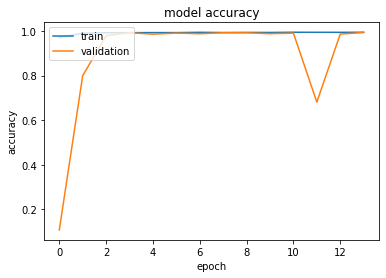

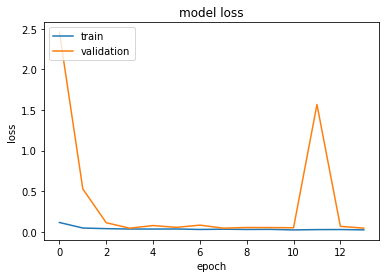

In [ ]:
MyFunctions.plot_history(history)

#*Test*

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_batches = test_datagen.flow_from_dataframe(
    df_test, 
    directory='/content/',
    x_col='Path',y_col='class_name',
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=1,
    seed=42,
    class_mode="categorical"
    )

Found 4928 validated image filenames belonging to 4 classes.


In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./04. Weights/Filtro_Unico.h5')

In [ ]:
result_test=model.predict(test_batches, verbose=1)
print(result_test.shape)
pd.DataFrame(result_test).to_csv('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/02. Exp 1: Cantidad de etapas de Filtrado/Results/result_test_Filtro_unico.csv')

4928/4928 [==============================] - 2544s 510ms/step
(4928, 4)


In [ ]:
#Obtenemos el nombre de clase asociado a cada indice
classes_dict = dict(zip(test_batches.class_indices.values(),test_batches.class_indices.keys()))
classes_dict

{0: 'AP_horizontal', 1: 'L', 2: 'Otro', 3: 'PA'}

In [ ]:
preds_classes, gts = MyFunctions.after_test(classes_dict,result_test,test_batches)

PA               2772
L                1434
Otro              570
AP_horizontal     152
dtype: int64
               precision    recall  f1-score   support

AP_horizontal       0.99      0.70      0.82       217
            L       0.99      1.00      1.00      1427
         Otro       1.00      1.00      1.00       568
           PA       0.98      1.00      0.99      2716

     accuracy                           0.98      4928
    macro avg       0.99      0.92      0.95      4928
 weighted avg       0.98      0.98      0.98      4928



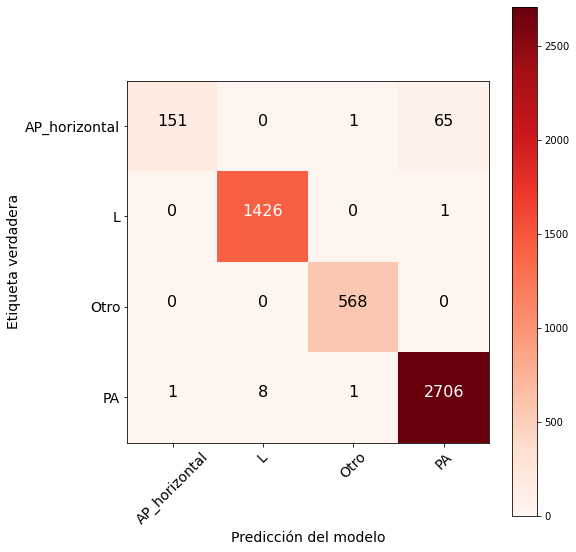

In [ ]:
MyFunctions.plot_confusion_matrix(gts,preds_classes,test_batches.class_indices.keys(),
                                  path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/02. Exp 1: Cantidad de etapas de Filtrado/Images/CM_Filtro_Unico')

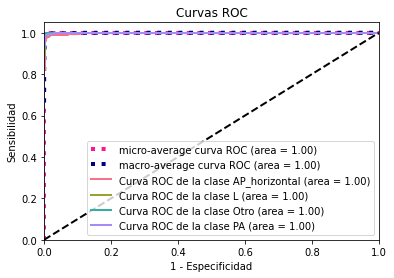

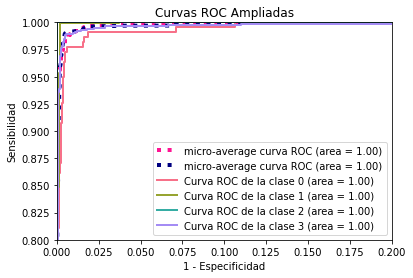

In [ ]:
MyFunctions.plot_ROC(result_test,gts,NUM_CLASSES, classes_dict,
                     path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/02. Exp 1: Cantidad de etapas de Filtrado/Images/ROC_Filtro_Unico')

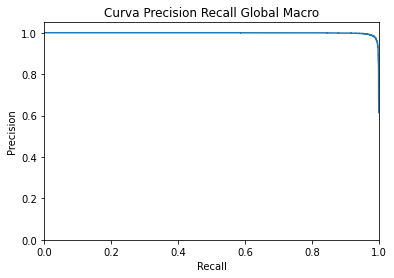

In [ ]:
MyFunctions.precision_recall_global(result_test,gts,NUM_CLASSES,
                     path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/02. Exp 1: Cantidad de etapas de Filtrado/Images/PRG_Filtro_Unico')

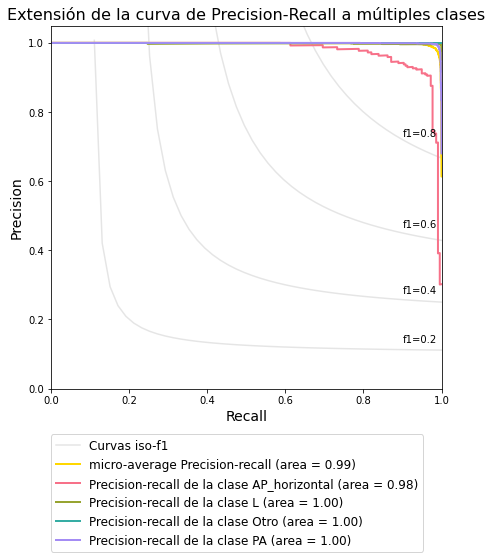

In [ ]:
MyFunctions.precision_recall_many(result_test,gts,NUM_CLASSES, classes_dict,
                                  path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/02. Exp 1: Cantidad de etapas de Filtrado/Images/PRM_Filtro_Unico')

# Guardado de Resultados Finales

In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/test_filter_set.csv")
df_res  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/02. Exp 1: Cantidad de etapas de Filtrado/Resultados/result_test_Filtro_unico.csv')

In [ ]:
df_res = df_res.drop(columns='Unnamed: 0')
df_res.columns

Index(['0', '1', '2', '3'], dtype='object')

In [ ]:
classes_dict = {0:'AP_horizontal',1:'L',2:'Otro',3:'PA'}
preds_classes = MyFunctions.after_test(classes_dict,df_res.to_numpy(),both=0)

PA               2772
L                1434
Otro              570
AP_horizontal     152
dtype: int64


In [ ]:
df_test["Pred"] = preds_classes

In [ ]:
df_test.head()

,Unnamed: 0,unnamed,Path,ImgType,class_name,Pred
0,4085,4085,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA,PA
1,3327,3327,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA,PA
2,3740,3740,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA,PA
3,1950,1950,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA,PA
4,4297,4297,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA,PA


In [ ]:
df_test = df_test.rename(columns={'Path':'ImageID','class_name':'Projection'})

In [ ]:
df_test["result"] = df_test["Projection"]==df_test["Pred"]
df_test.head()

,Unnamed: 0,unnamed,ImageID,ImgType,Projection,Pred,result
0,4085,4085,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA,PA,True
1,3327,3327,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA,PA,True
2,3740,3740,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA,PA,True
3,1950,1950,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA,PA,True
4,4297,4297,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA,PA,True


In [ ]:
df_test = df_test.drop(columns= (['unnamed','Unnamed: 0']))

In [ ]:
df_test.head()

,ImageID,ImgType,Projection,Pred,result
0,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA,PA,True
1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA,PA,True
2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA,PA,True
3,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA,PA,True
4,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA,PA,True


In [ ]:
df_test.to_csv('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/02. Exp 1: Cantidad de etapas de Filtrado/Resultados/Resultado_final_filtro_unico.csv')

#Análisis de predicciones incorrectas
Además de mostrarse cada una de las imágenes con el resultado de su predicción y su GT, se guardan en la carpeta correspondiente en el save_path, separadas en imágenes bien clasificadas y mal clasificadas (argumento bad=True/False) 

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/02. Exp 1: Cantidad de etapas de Filtrado/Resultados/Resultado_final_filtro_unico.csv')

In [ ]:
df_test_bad=df_test[df_test["result"]==False]
df_test_bad.head()

,ImageID,ImgType,Projection,Pred,result
266,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,AP_horizontal,AP_horizontal,PA,False
356,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,AP_horizontal,AP_horizontal,PA,False
358,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,AP_horizontal,AP_horizontal,PA,False
398,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,AP_horizontal,AP_horizontal,PA,False
491,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,AP_horizontal,AP_horizontal,PA,False


In [ ]:
os.chdir('/content/')

In [ ]:
image_path = '/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/'
save_path  = '/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/02. Exp 1: Cantidad de etapas de Filtrado/Resultados/Imágenes/Filtro_unico'
MyFunctions.save_image_results(df_test_bad,image_path,save_path,complete_path=True,plot=True)

Output hidden; open in https://colab.research.google.com to view.

# Análisis de Predicciones Correctas
Como la mayor parte de las imágenes fueron correctamente clasificadas, se trabaja con una muestra. 

In [ ]:
df_test_good = df_test[df_test["result"]==True]
df_test_good.head()

,ImageID,ImgType,Projection,Pred,result
0,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA,PA,True
1,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA,PA,True
2,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA,PA,True
3,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA,PA,True
4,/content/drive/MyDrive/Quinto_Anio/TESIS_Eugen...,PA,PA,PA,True


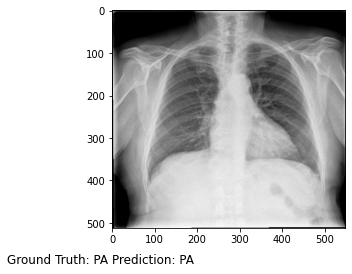

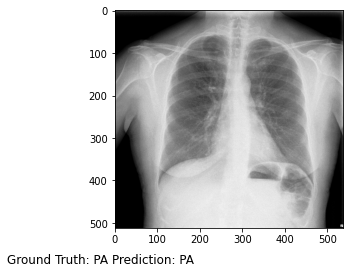

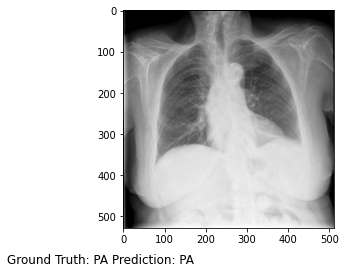

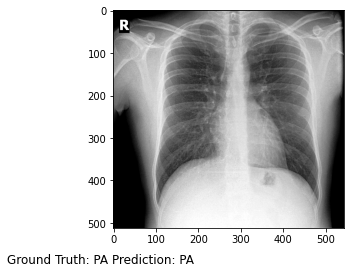

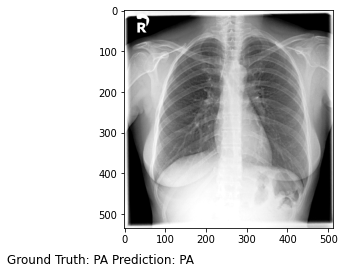

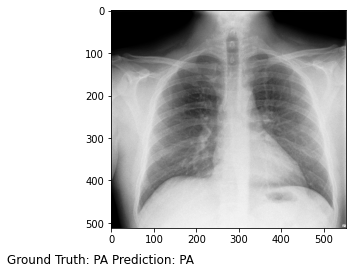

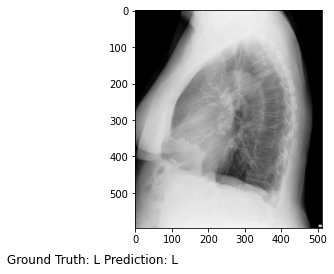

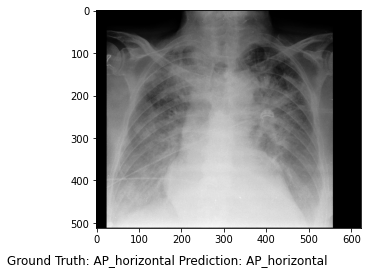

In [ ]:
MyFunctions.save_image_results(df_test_good[0:8],image_path,save_path,complete_path=True,bad = False,plot=True)